<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import regularizers

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
train_images = train_images / 255.0

test_images = test_images / 255.0

In [5]:
model = tf.keras.Sequential()

model.add(layers.Flatten(input_shape=(28, 28)))
# model.add(layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.000001)))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='sigmoid', kernel_regularizer=regularizers.l2(0.00001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='sigmoid', kernel_regularizer=regularizers.l2(0.00001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(500, activation='sigmoid', kernel_regularizer=regularizers.l2(0.000001)))
# model.add(layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.000001)))
# # model.add(layers.Dense(80, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.000001)))
# model.add(layers.Dropout(0.5))
# # model.add(layers.Dense(40, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.Dense(10, activation='softmax'))
# model.add(layers.Softmax())

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [7]:
# model.compile(optimizer='rmsprop',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

In [8]:
# model.fit(train_images, train_labels, epochs=20)
history = model.fit(train_images,
                    train_labels,
                    epochs=20,
                    batch_size=128,
                    validation_data=(test_images, test_labels))
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy:', test_acc)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


469/469 [==============================] - 16s 27ms/step - loss: 0.8303 - accuracy: 0.8209 - val_loss: 0.6573 - val_accuracy: 0.8298
Epoch 2/20
469/469 [==============================] - 9s 19ms/step - loss: 0.5636 - accuracy: 0.8519 - val_loss: 0.5671 - val_accuracy: 0.8337
Epoch 3/20
469/469 [==============================] - 5s 12ms/step - loss: 0.4977 - accuracy: 0.8585 - val_loss: 0.5067 - val_accuracy: 0.8531
Epoch 4/20
469/469 [==============================] - 6s 14ms/step - loss: 0.4663 - accuracy: 0.8636 - val_loss: 0.4909 - val_accuracy: 0.8552
Epoch 5/20
469/469 [==============================] - 6s 12ms/step - loss: 0.4516 - accuracy: 0.8661 - val_loss: 0.4844 - val_accuracy: 0.8493
Epoch 6/20
469/469 [==============================] - 6s 14ms/step - loss: 0.4400 - accuracy: 0.8688 - val_loss: 0.4583 - val_accuracy: 0.8611
Epoch 7/20
469/469 [==============================] - 6s 12ms/step - loss: 0.4260 - accuracy: 0.8725 - val_loss: 0.4887 - val_accuracy: 0.8469
Epoch 8/2

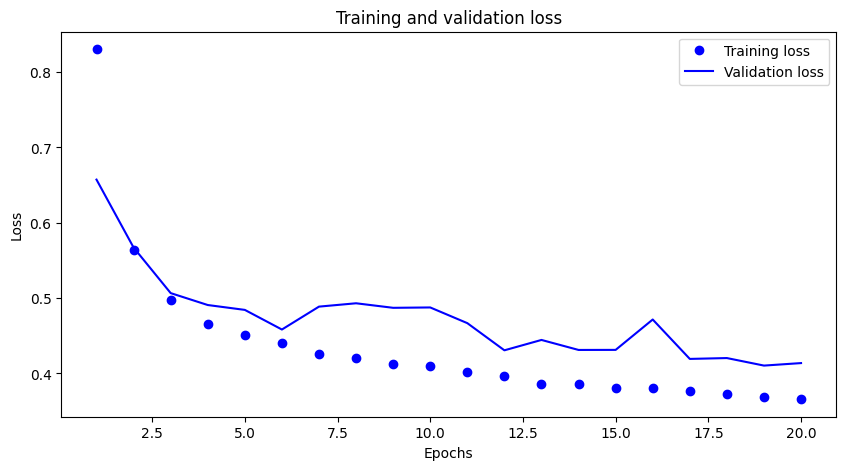

<Figure size 640x480 with 0 Axes>

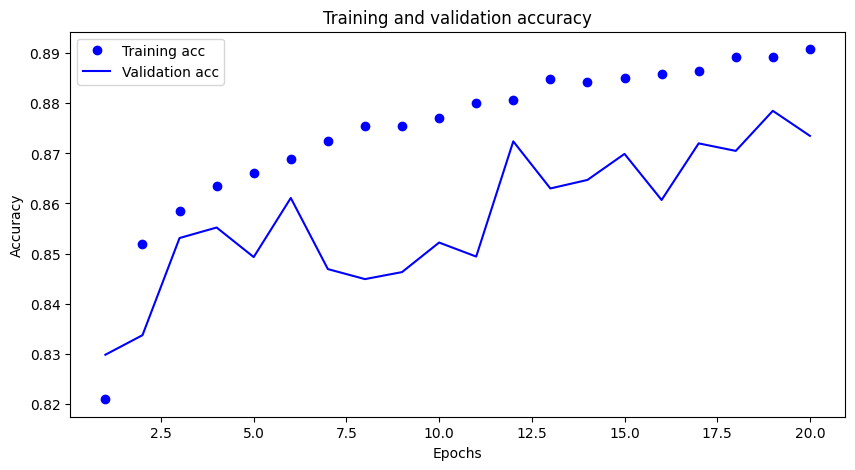

In [9]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [10]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [11]:
predictions = probability_model.predict(test_images)

313/313 [==============================] - 1s 2ms/step


In [12]:
predictions[0]

array([0.08679368, 0.08679245, 0.08679306, 0.08679288, 0.08679421,
       0.08956765, 0.08679426, 0.09568481, 0.08690533, 0.20708168],
      dtype=float32)